In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale images
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create DataLoaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # 1 input channel, 16 output channels
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) # 16 input channels, 32 output channels

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 512)  # 32 channels with 7x7 feature maps after pooling
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

        # Activation, dropout, and batch normalization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        # Flatten the tensor
        x = x.view(-1, 32 * 7 * 7)

        # Fully connected layers with ReLU, dropout, and batch normalization
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Instantiate the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

# Testing loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 347kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.77MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.58MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1/5, Loss: 0.1185, Accuracy: 96.76%
Epoch 2/5, Loss: 0.0494, Accuracy: 98.48%
Epoch 3/5, Loss: 0.0362, Accuracy: 98.89%
Epoch 4/5, Loss: 0.0307, Accuracy: 99.00%
Epoch 5/5, Loss: 0.0239, Accuracy: 99.26%
Test Accuracy: 98.99%


In [ ]:

confusion_matrix = torch.zeros(10, 10, dtype=torch.int64)
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())


        for true_label, pred_label in zip(labels, predicted):
            confusion_matrix[true_label, pred_label] += 1


print("Confusion Matrix:\n", confusion_matrix)


precision = []
recall = []
f1_score = []

for i in range(10):
    tp = confusion_matrix[i, i].item()
    fp = confusion_matrix[:, i].sum().item() - tp
    fn = confusion_matrix[i, :].sum().item() - tp
    precision_i = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_i = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_i = 2 * precision_i * recall_i / (precision_i + recall_i) if (precision_i + recall_i) > 0 else 0
    precision.append(precision_i)
    recall.append(recall_i)
    f1_score.append(f1_i)

for i in range(10):
    print(f"Class {i}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1-Score={f1_score[i]:.4f}")
avg_precision = sum(precision) / len(precision)
avg_recall = sum(recall) / len(recall)
avg_f1_score = sum(f1_score) / len(f1_score)
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f}")


Confusion Matrix:
 tensor([[ 972,    0,    1,    0,    0,    0,    5,    1,    1,    0],
        [   0, 1134,    0,    0,    0,    0,    0,    0,    1,    0],
        [   1,    0, 1025,    1,    0,    0,    2,    3,    0,    0],
        [   0,    0,    0, 1003,    1,    3,    0,    1,    2,    0],
        [   0,    0,    1,    0,  972,    0,    3,    0,    2,    4],
        [   0,    0,    0,    2,    0,  885,    1,    1,    3,    0],
        [   3,    5,    0,    1,    3,    3,  939,    0,    4,    0],
        [   0,    6,    3,    1,    1,    0,    0, 1012,    3,    2],
        [   1,    1,    1,    2,    0,    2,    0,    1,  966,    0],
        [   0,    1,    0,    2,    9,    4,    2,    5,   20,  966]])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 4 images.


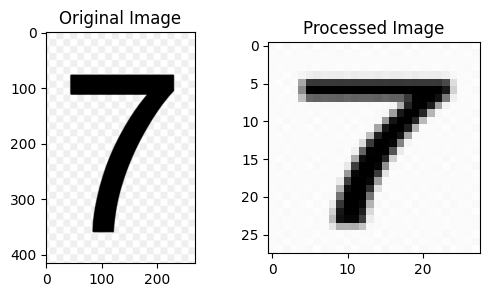

Image: /content/drive/My Drive/test_images/Screenshot 2024-12-06 173335.png, Predicted Class: 7


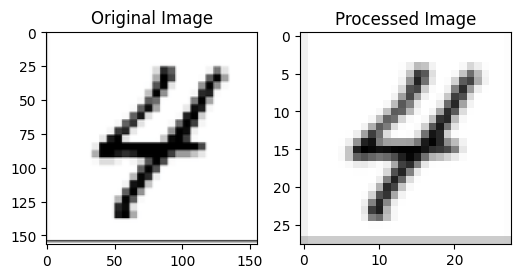

Image: /content/drive/My Drive/test_images/Screenshot 2024-12-05 192948.png, Predicted Class: 4


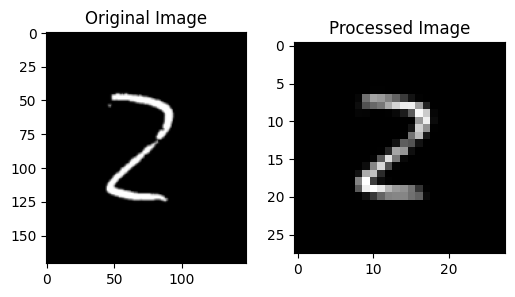

Image: /content/drive/My Drive/test_images/Screenshot 2024-12-18 200343.png, Predicted Class: 2


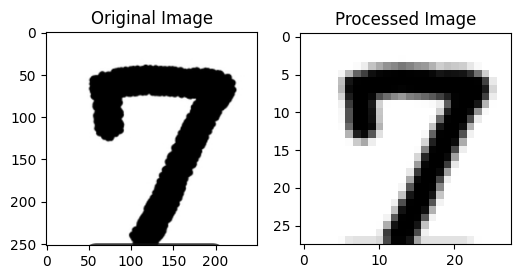

Image: /content/drive/My Drive/test_images/Screenshot 2024-12-06 173445.png, Predicted Class: 5


In [ ]:
from google.colab import drive
import os
import cv2
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


drive.mount('/content/drive')


test_images_folder = '/content/drive/My Drive/test_images'


image_files = [os.path.join(test_images_folder, f) for f in os.listdir(test_images_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
print(f"Found {len(image_files)} images.")


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


def test_single_image(image_path, model, transform):

    model.eval()


    image = Image.open(image_path).convert('RGB')
    original_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)


    processed_image = transform(image).unsqueeze(0).to(device)


    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(processed_image.squeeze().cpu().numpy(), cmap='gray')
    plt.title("Processed Image")
    plt.show()


    with torch.no_grad():
        output = model(processed_image)
        _, predicted = torch.max(output, 1)

    return original_image, predicted.item()


model.eval()
for image_path in image_files:
    original_image, predicted_class = test_single_image(image_path, model, transform)
    print(f"Image: {image_path}, Predicted Class: {predicted_class}")


